0. Import Libraries

In [ ]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from src.io import load_dataset
from src.preprocess import z_norm_per_series
from src.features import compute_group_pivots
from src.viz import plot_all_activity_variability, plot_fft_grid, plot_correlation_matrix, plot_one_sample_per_label   

#### 1. Data Import

In [77]:
data_dir = "../data/raw"
X_train, X_test, y_train, y_test = load_dataset(data_dir)

#### 2. Dataset Overview

In [78]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Compute class distributions for train and test sets
classes_train, counts_train = np.unique(y_train, return_counts=True)
classes_test, counts_test = np.unique(y_test, return_counts=True)

# Display the number of samples per class
for c, n_tr, n_te in zip(classes_train, counts_train, counts_test):
    print(f"Class {c}: train = {n_tr}, test = {n_te}")

X_train: (277, 9, 128)
y_train: (277,)
X_test: (70, 9, 128)
y_test: (70,)
Class 1: train = 76, test = 19
Class 2: train = 42, test = 11
Class 3: train = 39, test = 10
Class 4: train = 38, test = 9
Class 5: train = 42, test = 11
Class 6: train = 40, test = 10


The data can be summarized as follows:

| Label | Number of Observations | Physical Activity     |
|-------|------------------------|-----------------------|
| 1     | 95                     | walking               |
| 2     | 53                     | climbing stairs       |
| 3     | 49                     | descending stairs     |
| 4     | 47                     | sitting position      |
| 5     | 53                     | standing position     |
| 6     | 50                     | lying position        |


In [79]:
# Dictionary mapping labels to human activity names
label_to_activity = {
    1: "Walking",
    2: "Walking upstairs",
    3: "Walking downstairs",
    4: "Sitting",
    5: "Standing",
    6: "Lying"
}

unique_labels, counts = np.unique(y_train, return_counts=True)
summary_df = pd.DataFrame({
    "Label": unique_labels,
    "Activity": [label_to_activity[l] for l in unique_labels]
})

#### 3. Missing Data Check

In [80]:
nan_ratio = np.isnan(X_train).mean()
print(f"Missing Data in X : {nan_ratio}")

Missing Data in X : 0.0


#### 4. Analysis: Sensor Group Statistics per Activity

In [85]:
# Indices for each group
group_to_indices = {
    "accm": [0,1,2],
    "acce": [3,4,5],
    "vit":  [6,7,8],
}
mean_pivot, std_pivot, energy_pivot = compute_group_pivots(X_train, y_train, label_to_activity, group_to_indices)

print("Mean per group:")
display(mean_pivot.round(4))
print("Std per group:")
display(std_pivot.round(4))
print("Energy per group:")
display(energy_pivot.round(4))

Mean per group:


Group,acce,accm,vit
Activity,,,
Lying,-0.0077,0.4404,0.0136
Sitting,0.0026,0.4958,-0.0081
Standing,0.0003,0.2534,0.0016
Walking,-0.0001,0.2210,-0.0074
Walking downstairs,0.0033,0.2311,-0.0015
Walking upstairs,-0.0017,0.1804,0.0137


Std per group:


Group,acce,accm,vit
Activity,,,
Lying,0.0773,0.2802,0.1482
Sitting,0.0339,0.0866,0.0854
Standing,0.0081,0.0484,0.0270
Walking,0.1868,0.1885,0.5079
Walking downstairs,0.2152,0.2158,0.5556
Walking upstairs,0.1881,0.1865,0.5204


Energy per group:


Group,acce,accm,vit
Activity,,,
Lying,0.0063,0.3301,0.0277
Sitting,0.0012,0.3414,0.0075
Standing,0.0001,0.3597,0.0008
Walking,0.0364,0.3932,0.2860
Walking downstairs,0.0538,0.4064,0.3193
Walking upstairs,0.0357,0.3862,0.3218


#### Results Interpretation

The mean of the raw data is not representative in this case, because the signals contain both positive and negative values that cancel each other out.  
Thus, average amplitudes close to zero do not indicate an absence of movement, but rather an oscillation of the signal around an equilibrium point.  
To properly assess the intensity of the movement, it is therefore more relevant to analyze measures such as the standard deviation or the signal energy.

1. **Static activities (Lying, Sitting, Standing)**  
   - Very low energy on `acce` (estimated acceleration) and `vit` (velocity) → almost no movement.  
   - Stable energy values on `accm` (measured acceleration) around 0.33–0.36 → this corresponds to the gravitational component perceived by the sensor when it remains stationary but oriented differently depending on the posture (sitting, standing, lying).  

2. **Dynamic activities (Walking, Walking upstairs, Walking downstairs)**  
   - Strong increase in energy on `acce` and `vit` → rapid variations in acceleration and velocity reflect rhythmic and regular activity.  
   - Slight increase in energy on `accm` (0.39–0.41) → the gravity component is still present but superimposed on dynamic accelerations due to movement.  

#### 5. Visualization: One Representative Sample per Activity

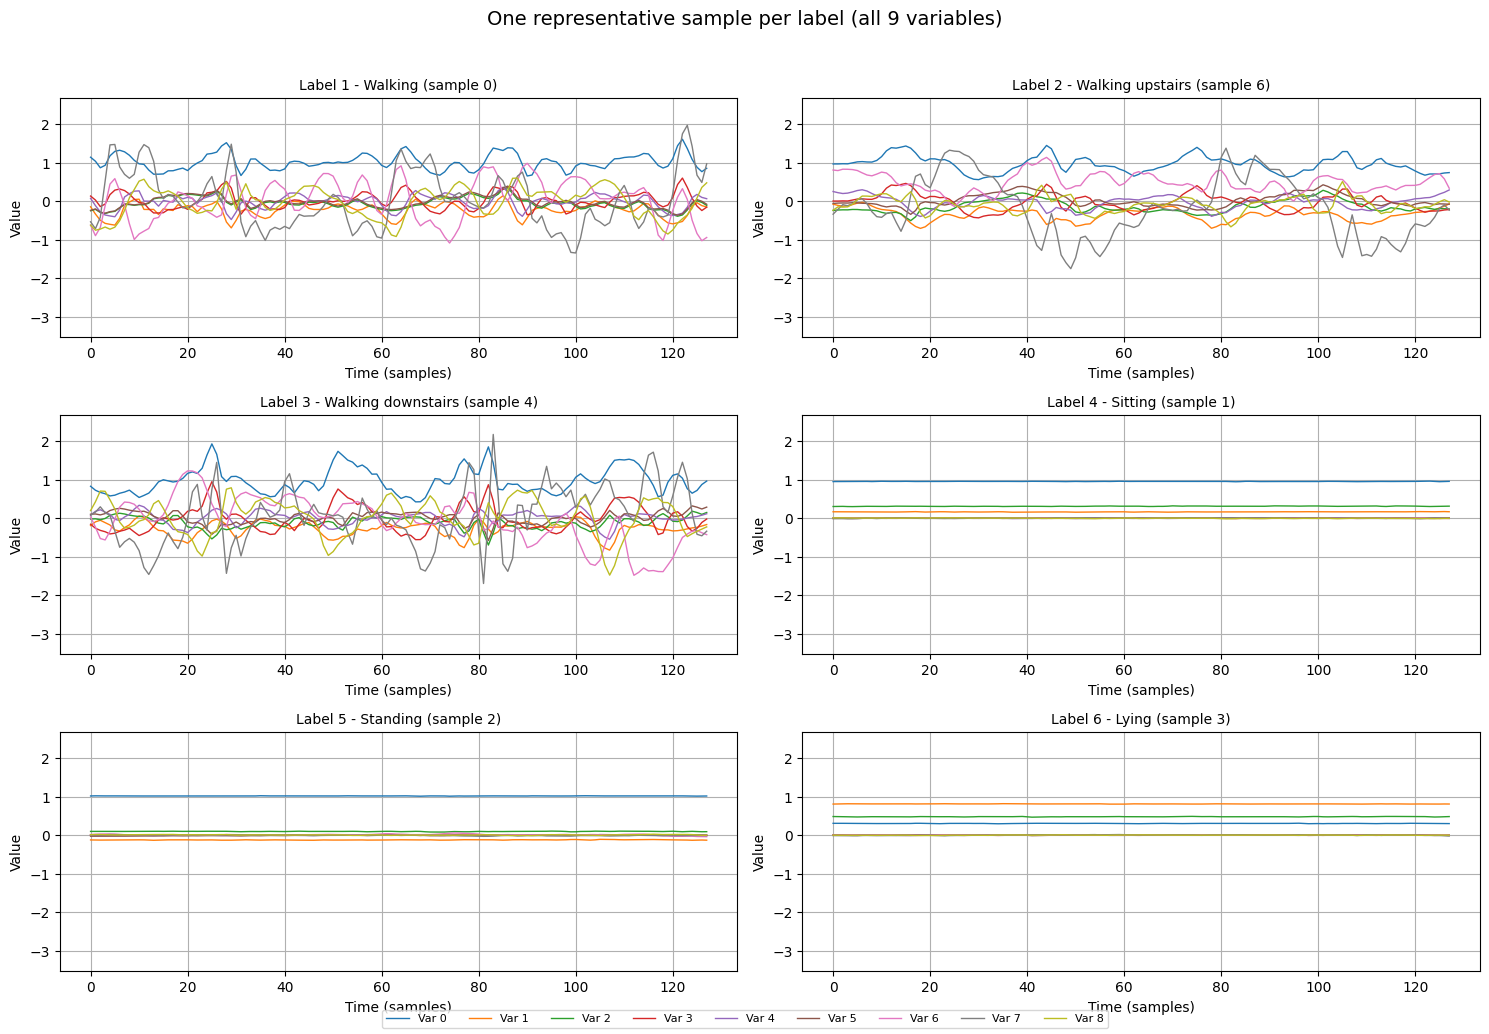

In [81]:
plot_one_sample_per_label(X_train, y_train, label_to_activity, n_cols=2, figsize=(15,10))

#### Results Interpretation
1. **Dynamic activities (Labels 1–3):** The first three graphs show:
   - Strong oscillations in several variables.  
   - Periodic patterns on the x and y axes, characteristic of regular movements (walking, climbing, or descending).  
   - Similar variations across the 9 sensors, meaning that speeds and accelerations change simultaneously.  

2. **Static activities (Labels 4–6):** The other three graphs show:
   - Almost flat curves with very little variance.  
   - Constant and positive values on some dimensions.  

3. **Conclusion:** Comparing the amplitudes:
   - Dynamic activities have values roughly between -1.8 and +2.  
   - Static activities fall within the [0, 1] range, with very little dispersion.  

#### 6. Visualization: Temporal Variability per Activity

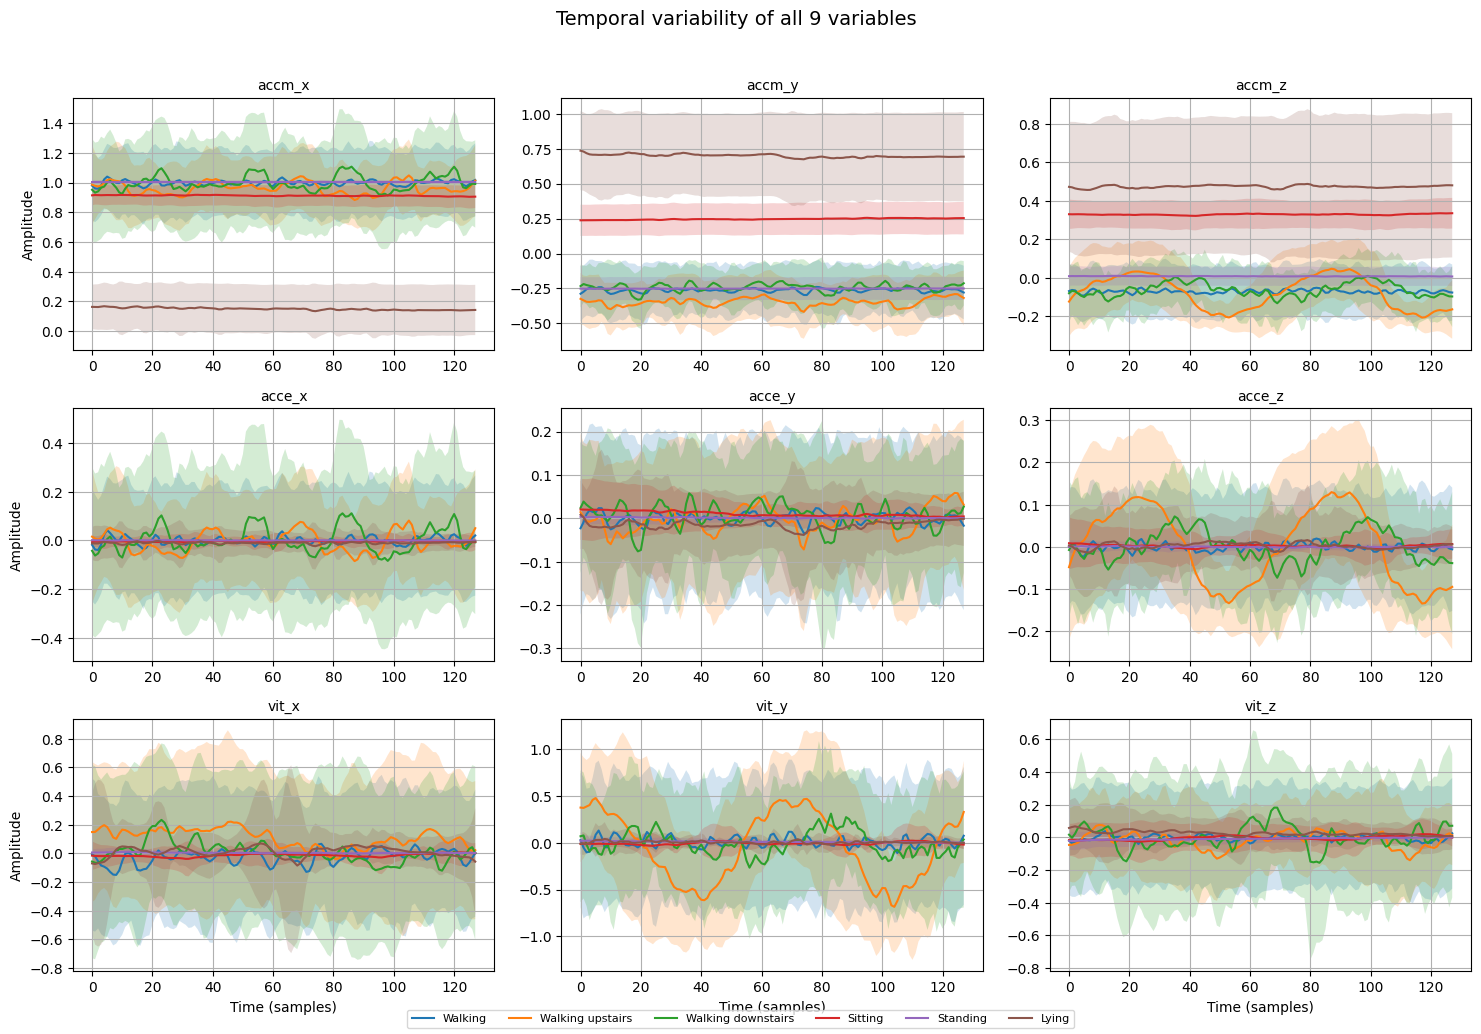

In [86]:
var_names = [
    "accm_x", "accm_y", "accm_z",
    "acce_x", "acce_y", "acce_z",
    "vit_x", "vit_y", "vit_z"
]
plot_all_activity_variability(X_train, y_train, label_to_activity, var_names)


#### Results Interpretation
1. **accm sensors (measured accelerations):** `accm_x / accm_y / accm_z`  
   - The activities **Sitting, Standing, Lying** show flat curves corresponding to a generally constant acceleration, indicating an absence of significant movement.  
   - The activities **Walking, Upstairs, Downstairs** show clear oscillations around a mean value, representing periodic movement.  

2. **acce sensors (estimated accelerations):** `acce_x / acce_y / acce_z`  
   - The amplitudes are centered around 0, since the gravitational component has been removed.  
   - Dynamic activities (walking, going upstairs/downstairs) still show clear and regular oscillations with higher amplitude, reflecting active motion.  
   - Static activities remain close to zero, with very little variance.  

3. **vit sensors (estimated velocities):** `vit_x / vit_y / vit_z`  
   - The velocity signals are also centered around zero but exhibit greater variability and sometimes noise, as a consequence of integrating the accelerations.  
   - Dynamic activities still display some temporal structure, whereas static activities remain almost constant.  



#### 7. Visualization: Frequency Analysis across Multiple Sensors

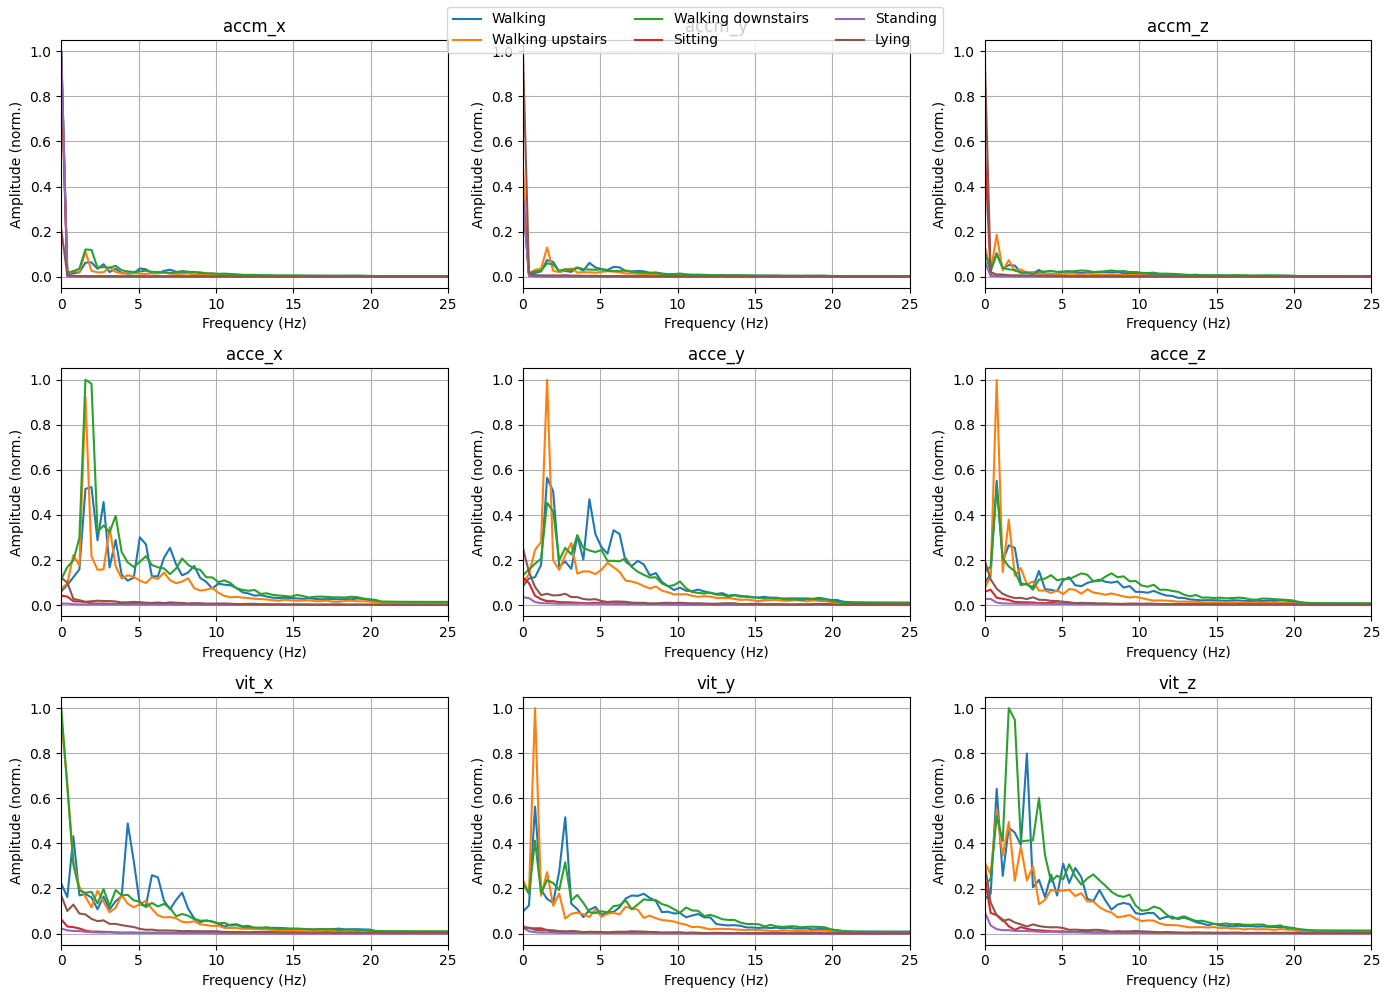

In [87]:
plot_fft_grid(X_train, y_train, label_to_activity, var_names, normalize=True)

#### Results Interpretation

1. **General Reading of the Graph**

Each subfigure represents the average frequency spectrum of a variable (x-axis = frequency in Hz, y-axis = normalized amplitude).  
The graph shows the average frequency spectrum obtained through the Fast Fourier Transform (FFT) applied to each sensor signal (accelerations and velocities) for all physical activities.  
The FFT (Fast Fourier Transform) is a mathematical method that transforms a signal from the time domain (values as a function of time) to the frequency domain (values as a function of frequency).  
In other words, it decomposes the signal into a sum of sinusoidal waves of different frequencies and amplitudes.  

- **Frequency axis (0–25 Hz):** half of the sampling rate (50 Hz); this is the useful band according to the Nyquist theorem.  
- **Amplitude:** indicates the signal strength at each frequency.  


2. **Global Observations**  
   - Most of the energy is concentrated in very low frequencies (0–5 Hz). This corresponds to human dynamics: body movements are slow compared to the sensor’s sampling rate.  
     Beyond 10 Hz, the spectrum is almost flat → the signal contains almost no fast components.  
   - The variables *accm* and *acce* (accelerations) show clear peaks between 1 and 3 Hz for some activities. These peaks correspond to step frequencies or periodic movements.  
   - Static activities (sitting, standing, lying) have a flat spectrum near zero. Their frequency amplitude is very low → little temporal variation → nearly constant signal.  


3. **Differences by Variable Group**  

**3.1. Measured Accelerations (accm_x, accm_y, accm_z)**  
   - Low overall amplitude → reflects constant gravity and micro-vibrations.  
   - Small peaks at low frequencies (0–3 Hz) occasionally indicate slight movement.  

**3.2. Estimated Accelerations (acce_x, acce_y, acce_z)**  
   - More pronounced spectra.  
   - Clear peaks between 1 and 3 Hz → periodic body movements.  
   - Static activities remain very low (almost 0 across the entire spectrum).  

**3.3. Velocities (vit_x, vit_y, vit_z)**  
   - Spectra similar to those of estimated accelerations but more spread out.  
   - Again, most of the energy is concentrated below 5 Hz.  

#### 8. Visualization: Correlation Matrix between Sensor Variables

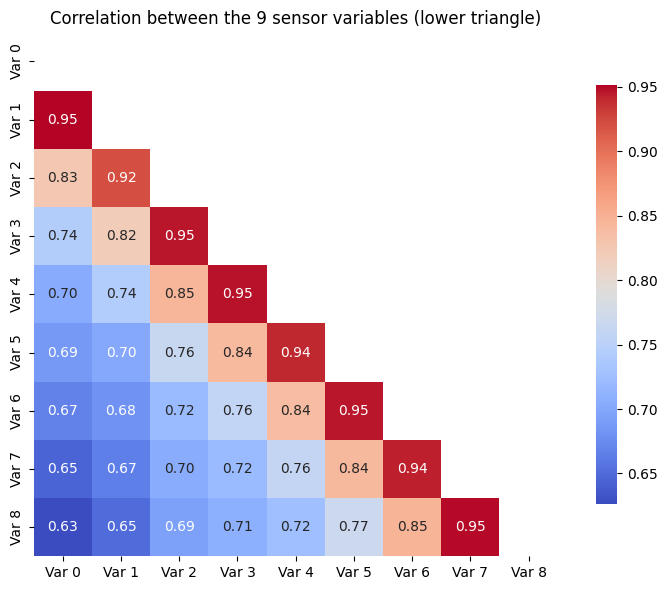

In [88]:
plot_correlation_matrix(X_train)

#### Results Interpretation
1. **General Structure**  
   The three axes (x, y, z) of the three variables (*acce*, *accm*, *vit*) are highly correlated, with coefficients around **0.9**.  

2. **Inter-group Correlations**  

   - **Between measured (Var 0–2) and estimated accelerations (Var 3–5):** moderate correlations (~0.7–0.8).  
     → The signals follow similar trends but are not identical; gravitational and filtering effects differentiate the two sets of measurements.  

   - **Between accelerations and velocities (Var 6–8):** lower correlations (~0.6–0.7).  
     → Velocities therefore provide complementary information related to the overall dynamics of movement.  

#### 9. Data Normalization

In [73]:
X_norm = z_norm_per_series(X_train)
print("Global mean after z-norm:", X_norm.mean())
print("Global std after z-norm:", X_norm.std())

Global mean after z-norm: -1.761304477493981e-17
Global std after z-norm: 1.0


#### Explanation 
Before clustering, we analyzed the amplitude scales across the nine sensor variables.
Since their standard deviations differ significantly and some clustering algorithms (as DBA-k-means and k-shape) assume normalized input, we decided to apply per-series z-normalization (mean = 0, std = 1).
This step ensures that the clustering focuses on the temporal pattern rather than the absolute magnitude of the signals.